# The difference is defined by initial state of ESN

# initialization of ESN

二つのESNの内部状態の初期値を変えて、その差を見る関数を作る.

初期値はseedで管理

## ESN, output, input class
input, output, middle layer

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt
import copy

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        #only first neuron receives noise
        #self.w_in = np.zeros((dim_x, dim_u))
        #self.w_in[:, 0]=np.random.uniform(-input_scale, input_scale, dim_u).T
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)

    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, input_scale=1.0, eps=0.20, r=4.0, dtype=np.float32, rseed=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=0)
        self.input_scale=input_scale # variant for buf
        self.dtype = dtype
        self.w_in = np.random.uniform(-self.input_scale, self.input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=eps # diffusive coupling strength
        self.r=r # control parameter r

        np.random.seed(seed=rseed)
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        #print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_x_in(self):
        return np.array(self.x_in_series)

    def __call__(self):
        self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
        self.x_in_spon=self.CML2d[0]-self.CML2d[1]
        #print(self.CML2d)
        self.x_in_series.append(self.x_in_spon)
        return np.dot(self.w_in, self.x_in_spon)# x_in is row or clumn??????

class ESN1:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        np.random.seed(seed=self.rseed)
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        np.random.seed(seed=self.rseed)
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))

        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
        """
        self.w_net  =[[1.0, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
            print("error")
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        
        self.x = self.f_act(np.dot(self.w_net, self.x) + x_in)
        #print("self.x[0] = ", buf_x[0], "  (np.dot(self.w_net, self.x) + x_in)[0] = ", (np.dot(self.w_net, self.x) + x_in)[0])
        #print("np.tanh( (np.dot(self.w_net, self.x) + x_in)[0]) =", np.tanh((np.dot(self.w_net, self.x) + x_in)[0]) )

    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


## Discrete ESN for checking state values

In [2]:
class DESN_2kindsInput_1(ESN1):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale_spon, activation_func, 
                 rseed=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, dim_out=0, x_init=None, **kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_1, self).__init__(dim_rv, activation_func=activation_func, rseed=rseed,
                                                 x_init=x_init, **kwargs)#assign dim_rv to dim_x
        #create instance
        ex_w_scale=1.0
        self.Input_external = Input_external(dim_u_ex, dim_rv, ex_w_scale, rseed=rseed)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, input_scale=input_scale_spon, eps=spon_eps, r=spon_r, rseed=seed_spon)
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update( (x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

## Observation of DESN with spontaneous acts

np.diff(): 渡した配列の階差数列を配列で返す関数

In [3]:
def DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=0.5, input_scale_spon=0.4, rseed=0, activation_func=np.tanh, 
                    washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, x_init=None, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_1(seed_spon=seed_spon, dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale_spon=input_scale_spon, activation_func=activation_func, 
                             spon_eps=spon_eps, spon_r=spon_r, rho=rho, rseed=rseed, x_init=x_init)
    
    washout_len=washout_len
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
        #print(states_series[0])

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        ax1[0].plot(time, x_in_spon)

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return x_in_spon, states_series


## observation example

Debug
dim_u =  1
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 100)


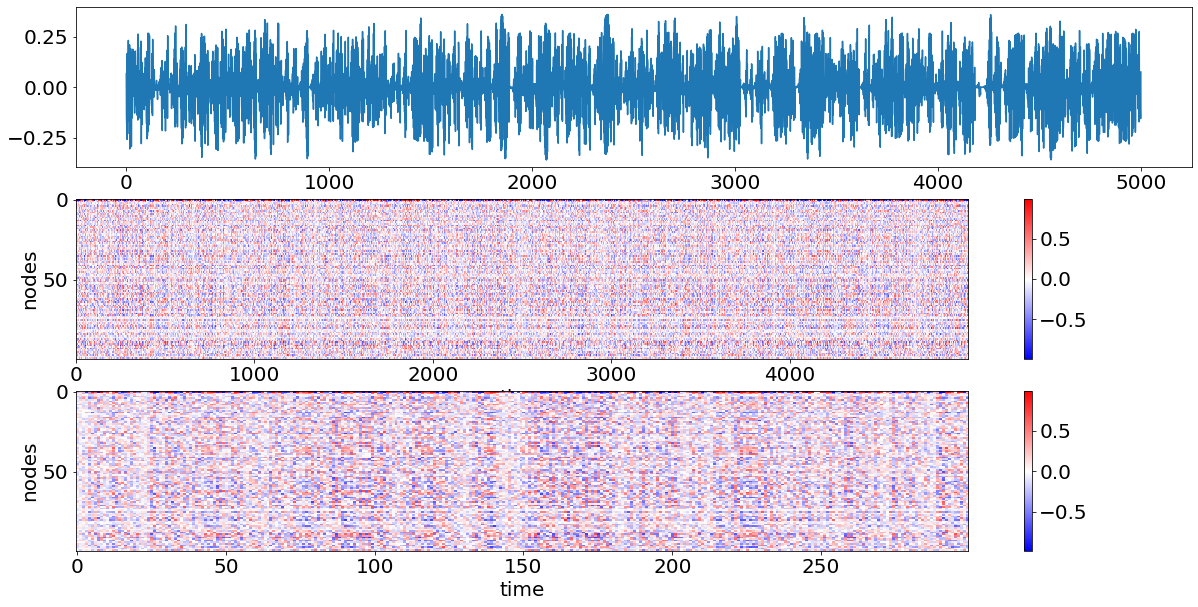

In [4]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=5000

x_init=np.random.uniform(-1.0, 1.0, dim_rv)
#print(x_init)

input_scale_spon=1.0
rho=0.9
density=1.0

#change external input_scale 0.01~1.0
ex_input_scale=1.0
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))


rseed=1111
x_in_spon, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                         rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                         spon_eps=0.20, spon_r=4.0, x_init=x_init, plot=True, verbose=True)

In [5]:
print(max(x_in_spon))


[0.35970944]


# ESPindex 1spon

## convergence of rhos, input_scale_spon=0.4,
check when to converge

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 2.1
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=1
dim_rv=50
dim_u=0
density=1.0

rhos = np.arange(pLow, pHigh, pInc)

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
input_scale_spon=0.4

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_spon_rhos=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    rho=rhos[i]

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_spon_rhos[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs rhos, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 2.0791]


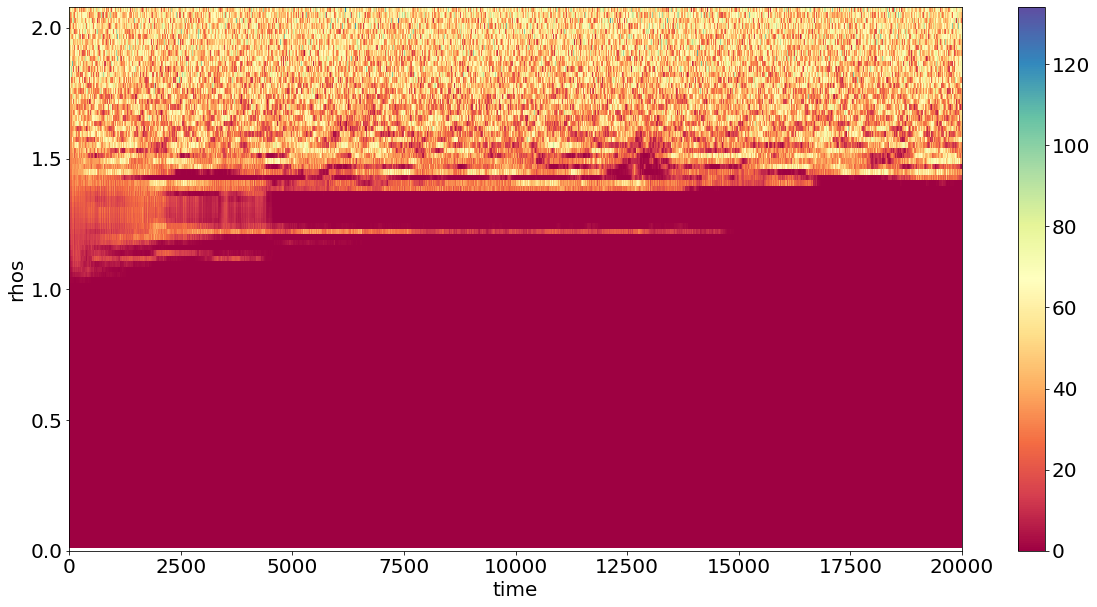

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)


dist=distance_spon_rhos.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, rhos[0], rhos[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', vmin=0, aspect='auto')#interpolation='nearest', 

ax1.set_xlabel('time')
ax1.set_ylabel('rhos')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)

### bifurcation

In [ ]:
import copy
np.random.seed(1010)
dim_u_spon=1
dim_rv=50
dim_u=0
Time_leng=2*10**4

input_scale_spon=0.4
density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111

pLow = 0.01
pHigh = 1.5
nSteps = 100       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rhos = np.arange(pLow, pHigh, pInc)
num_division=110
divided_range=np.linspace(-1.1, 1.1, num_division)
count_val=np.zeros((nSteps, num_division))

j_ofx=1
states_serieses=[]
np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
for i in range(nSteps):
    x_in_spon, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale_spon=input_scale_spon, rho=rhos[i], rseed=rseed, 
                                             seed_spon=100, spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    #washout_len: here, this value is 0. so define below again.
    washout_len=19000
    data=states_series[washout_len:, j_ofx]
    states_serieses.append(data)
    for val in data:
        #print(i, int(0.5*num_division+50*val))
        count_val[i, int(0.5*num_division+50*val)]+=1


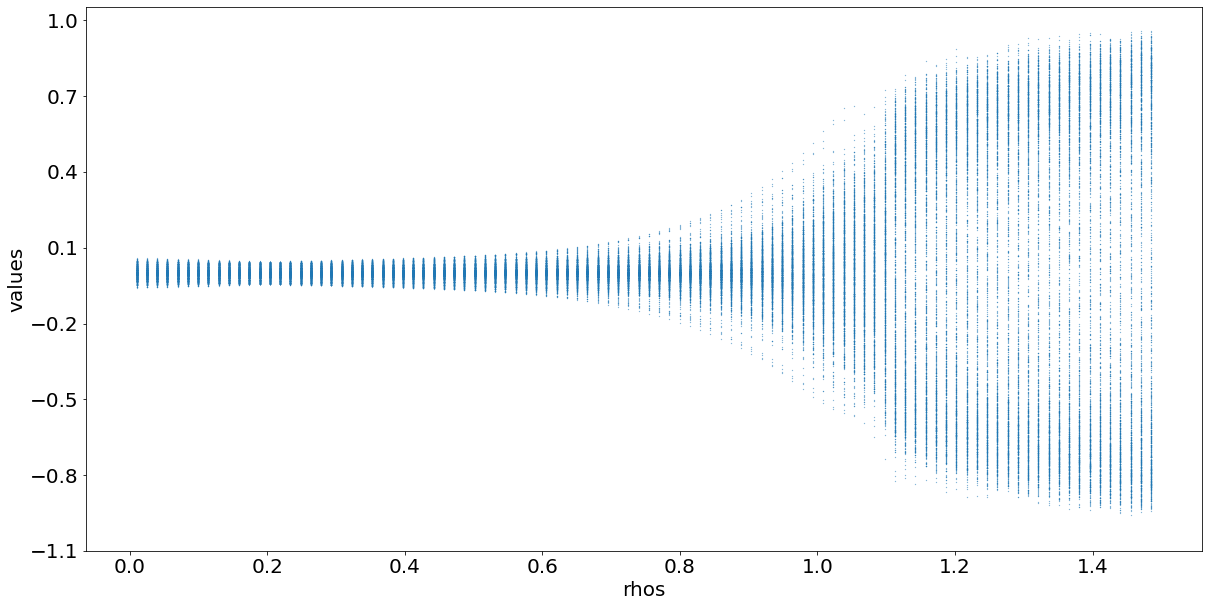

In [ ]:
np.set_printoptions(threshold=10)
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

np.set_printoptions(threshold=np.inf)
#print(plot_data)
np.set_printoptions(threshold=10)

ax1.scatter(np.tile(rhos, (1000, 1)).T, states_serieses, s=0.05)

ax1.set_xlabel('rhos')
ax1.set_ylabel('values')
ax1.set_yticks(np.arange(-1.1, 1.1, 0.3))

count_val.shape (100, 110)
cou.shape (110, 100)


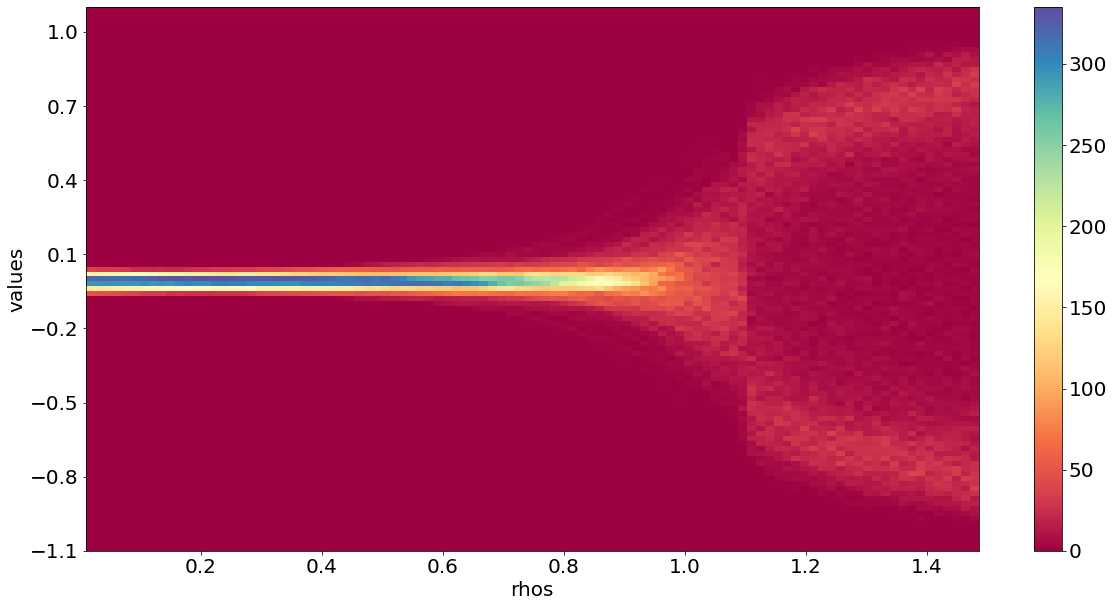

In [ ]:
np.set_printoptions(threshold=10)
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

print("count_val.shape", count_val.shape)
cou=count_val.T
print("cou.shape", cou.shape)

plot_data=cou[:-1:, :]

np.set_printoptions(threshold=np.inf)
#print(plot_data)
np.set_printoptions(threshold=10)

extent=[rhos[0], rhos[-1], -1.1, 1.1]
#print(extent)
bar1=ax1.imshow(plot_data, extent=extent, cmap='Spectral', interpolation='nearest', aspect='auto') #cmap='bwr',

ax1.set_xlabel('rhos')
ax1.set_ylabel('values')
ax1.set_yticks(np.arange(-1.1, 1.1, 0.3))
fig.colorbar(bar1, ax=ax1)

## convergence of input_scales_spon, rho=1.1, 
check when to converge

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 1.6
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=1
dim_rv=50
dim_u=0
density=1.0

input_scales_spon = np.arange(pLow, pHigh, pInc)

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
rho=1.1

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_spon_inputs=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    input_scale_spon=input_scales_spon[i]

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_spon_inputs[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs input_scales, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 1.5840999999999998]
8.009605407714844
i =  0  input_scale =  0.01
6.556825637817383
i =  1  input_scale =  0.0259
3.1687188148498535
i =  2  input_scale =  0.0418
1.1933995485305786
i =  3  input_scale =  0.057699999999999994
15.559233665466309
i =  12  input_scale =  0.20079999999999998
5.481101989746094
i =  13  input_scale =  0.21669999999999998


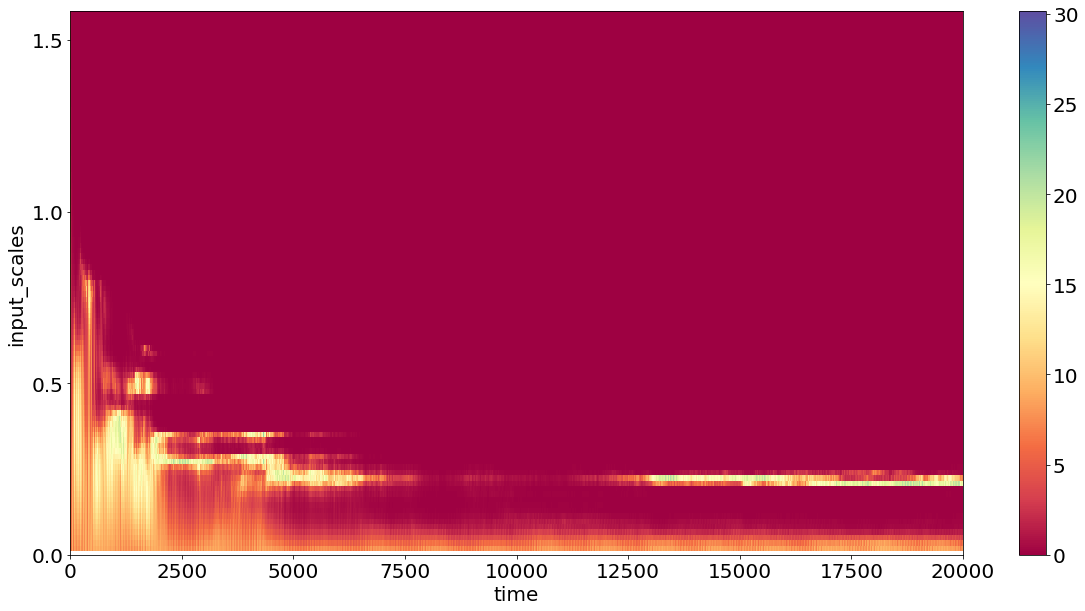

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

dist=distance_spon_inputs.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, input_scales_spon[0], input_scales_spon[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto')#interpolation='nearest', 

for i in range(plot_data.shape[0]):
    val=plot_data[i][-1]
    if val >1 and input_scales_spon[i]<1.5:
        print(val)
        print("i = ", i, " input_scale = ", input_scales_spon[i])
"""
interpolationについて
https://imagingsolution.net/imaging/interpolation/

a valid value for interpolation; supported values are 'antialiased', 'none', 
'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 
'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'
"""
ax1.set_xlabel('time')
ax1.set_ylabel('input_scales')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)

### bifurcation

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=50
dim_u=0
Time_leng=2*10**4

density=1.0

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
#print(u_ex)
rseed=1111

pLow = 0.01
pHigh = 1.60
nSteps = 100       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rho=1.1
input_scales_spon = np.arange(pLow, pHigh, pInc)

num_division=110
divided_range=np.linspace(-1.1, 1.1, num_division)
count_val=np.zeros((nSteps, num_division))

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)

j_ofx=1
states_serieses=[]
for i in range(nSteps):
    input_scale_spon=input_scales_spon[i]
    x_in_spon, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale_spon=input_scale_spon, rho=rho, rseed=rseed, 
                                             seed_spon=100, spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    #washout_len: here, this value is 0. so define below again.
    washout_len=19000
    data=states_series[washout_len:, j_ofx]
    states_serieses.append(data)
    for val in data:
        #print(i, int(0.5*num_division+50*val))
        count_val[i, int(0.5*num_division+50*val)]+=1


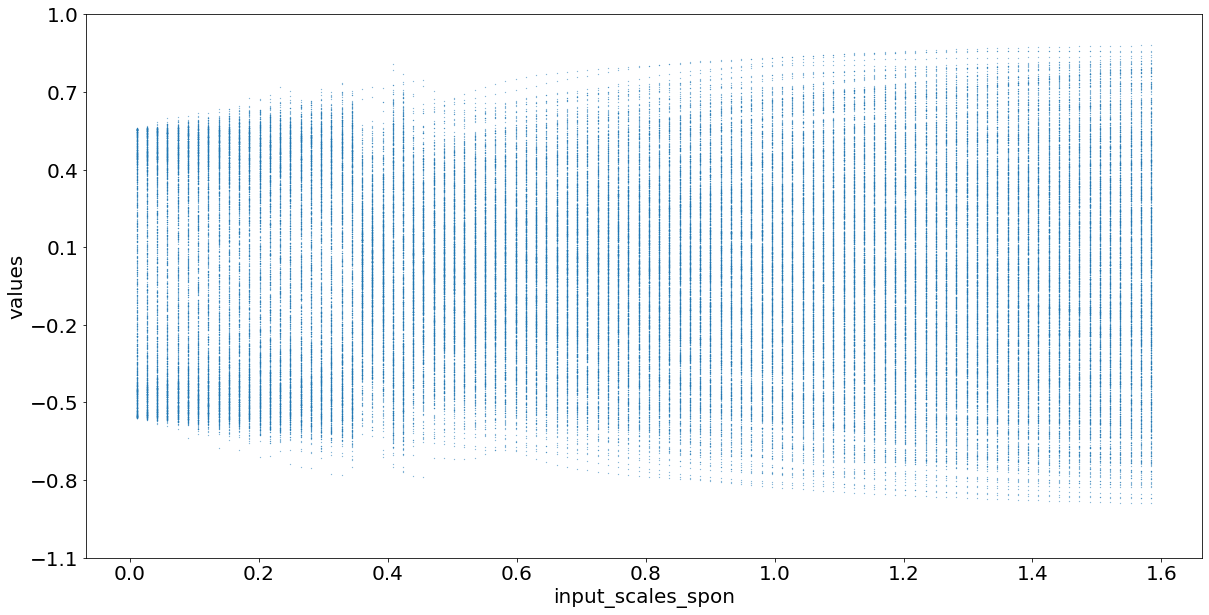

In [ ]:
np.set_printoptions(threshold=10)
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

np.set_printoptions(threshold=np.inf)
#print(plot_data)
np.set_printoptions(threshold=10)

ax1.scatter(np.tile(input_scales_spon, (1000, 1)).T, states_serieses, s=0.05)

ax1.set_xlabel('input_scales_spon')
ax1.set_ylabel('values')
ax1.set_yticks(np.arange(-1.1, 1.1, 0.3))


count_val.shape (100, 110)
cou.shape (110, 100)


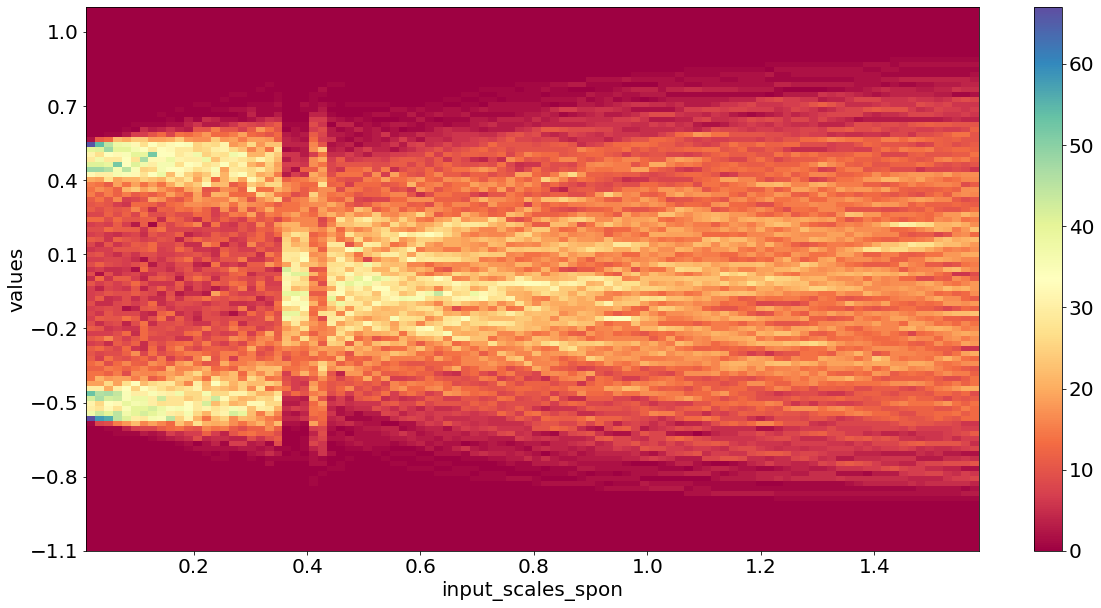

In [ ]:
np.set_printoptions(threshold=10)
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

print("count_val.shape", count_val.shape)
cou=count_val.T
print("cou.shape", cou.shape)

plot_data=cou[:-1:, :]

np.set_printoptions(threshold=np.inf)
#print(plot_data)
np.set_printoptions(threshold=10)

extent=[input_scales_spon[0], input_scales_spon[-1], -1.1, 1.1]
#print(extent)
bar1=ax1.imshow(plot_data, extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto') 

ax1.set_xlabel('input_scales_spon')
ax1.set_ylabel('values')
ax1.set_yticks(np.arange(-1.1, 1.1, 0.3))
fig.colorbar(bar1, ax=ax1)

# ESPindex 1spon, 1external

## convergence of rhos, input_scale_spon=0.4, ex_input_scale=0.1
check when to converge

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 2.1
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=1
dim_rv=50
dim_u=1
density=1.0

rhos = np.arange(pLow, pHigh, pInc)
ex_input_scale=0.1
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))
input_scale_spon=0.4

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_both_rhos=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    rho=rhos[i]

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_both_rhos[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs rhos, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 2.0791]


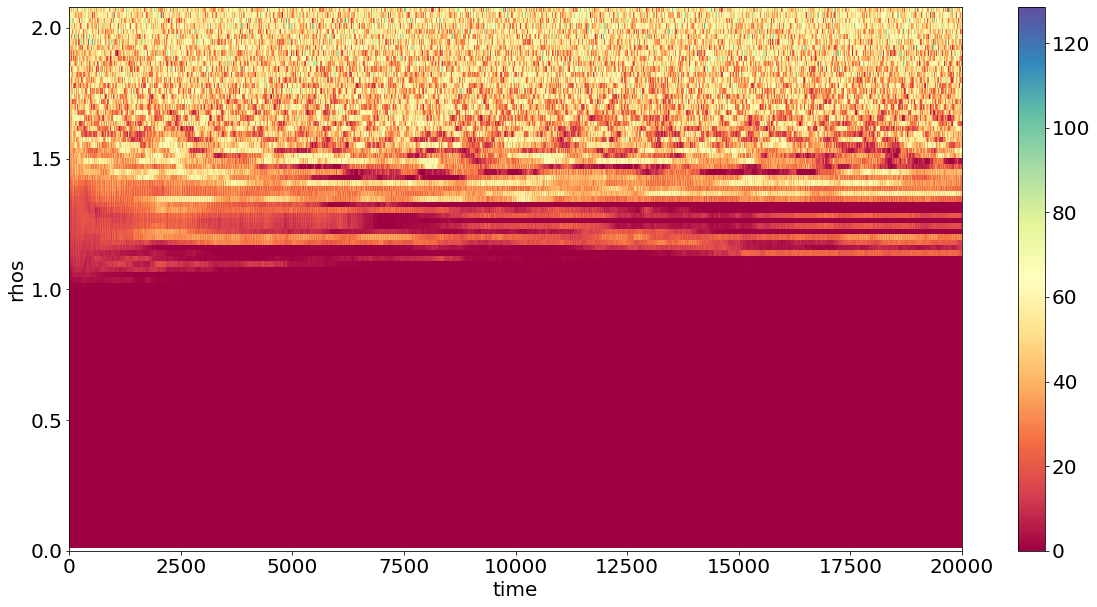

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)


dist=distance_both_rhos.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, rhos[0], rhos[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', vmin=0, aspect='auto')#interpolation='nearest', 

ax1.set_xlabel('time')
ax1.set_ylabel('rhos')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)

## convergence of input_scales_spon, rho=1.1, 
check when to converge

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 1.6
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=1
dim_rv=50
dim_u=1
density=1.0

input_scales_spon = np.arange(pLow, pHigh, pInc)
ex_input_scale=0.1
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))
rho=1.1

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_both_spons=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    input_scale_spon=input_scales_spon[i]

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_both_spons[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs input_scales, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 1.5840999999999998]


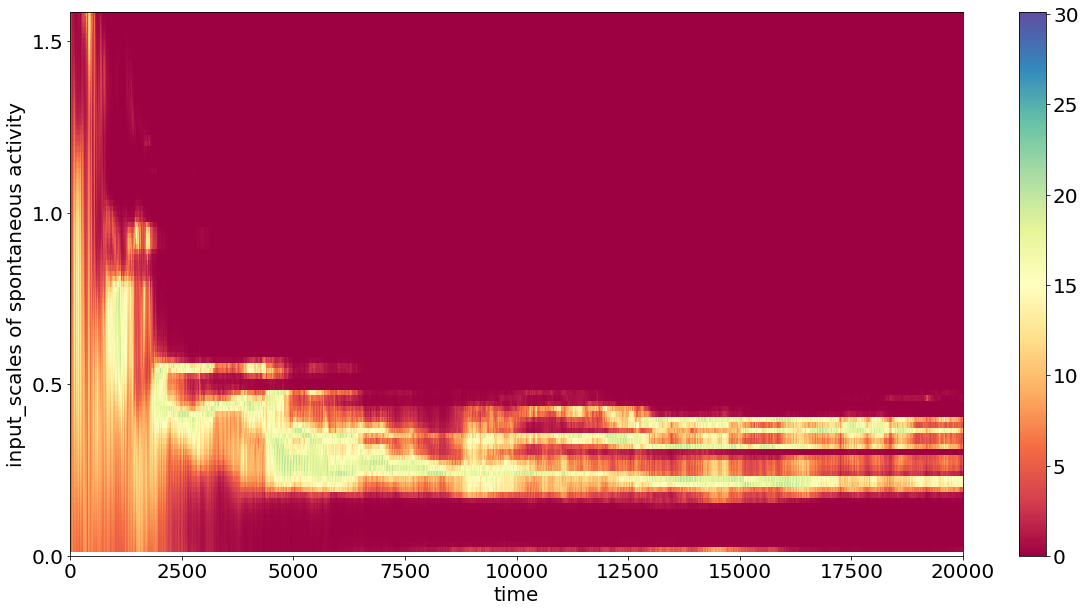

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

dist=distance_both_spons.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, input_scales_spon[0], input_scales_spon[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto')#interpolation='nearest', 
"""
interpolationについて
https://imagingsolution.net/imaging/interpolation/

a valid value for interpolation; supported values are 'antialiased', 'none', 
'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 
'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'
"""
ax1.set_xlabel('time')
ax1.set_ylabel('input_scales of spontaneous activity')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)

## convergence of ex_input_scales, rho=1.1, input_scale_spon = 0.4

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 1.6
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=1
dim_rv=50
dim_u=1
density=1.0

input_scale_spon = 0.4
ex_input_scales=np.arange(pLow, pHigh, pInc)
rho=1.1

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_both_exs=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    ex_input_scale=ex_input_scales[i]
    u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_both_exs[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs input_scales, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 1.5840999999999998]


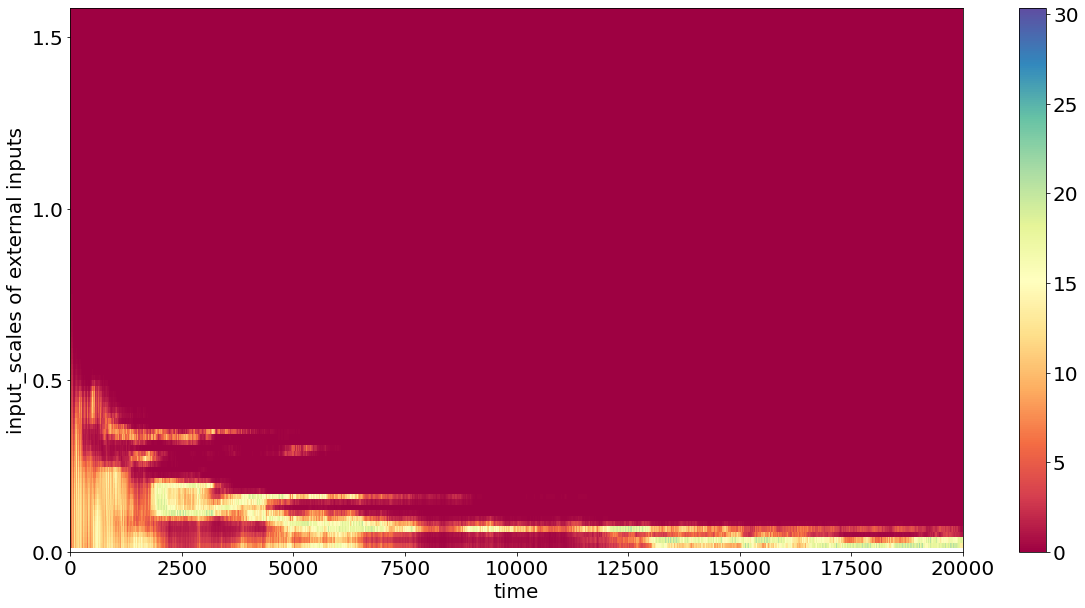

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

dist=distance_both_exs.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, ex_input_scales[0], ex_input_scales[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto')#interpolation='nearest', 
"""
interpolationについて
https://imagingsolution.net/imaging/interpolation/

a valid value for interpolation; supported values are 'antialiased', 'none', 
'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 
'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'
"""
ax1.set_xlabel('time')
ax1.set_ylabel('input_scales of external inputs')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)

# ESPindex 1external

## convergence of rhos, input_scale_spon=0.4, ex_input_scale=0.1
check when to converge

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 2.1
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=0
dim_rv=50
dim_u=1
density=1.0

rhos = np.arange(pLow, pHigh, pInc)
ex_input_scale=0.1
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))
input_scale_spon=0.4

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_ex_rhos=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    rho=rhos[i]

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_ex_rhos[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs rhos, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 2.0791]


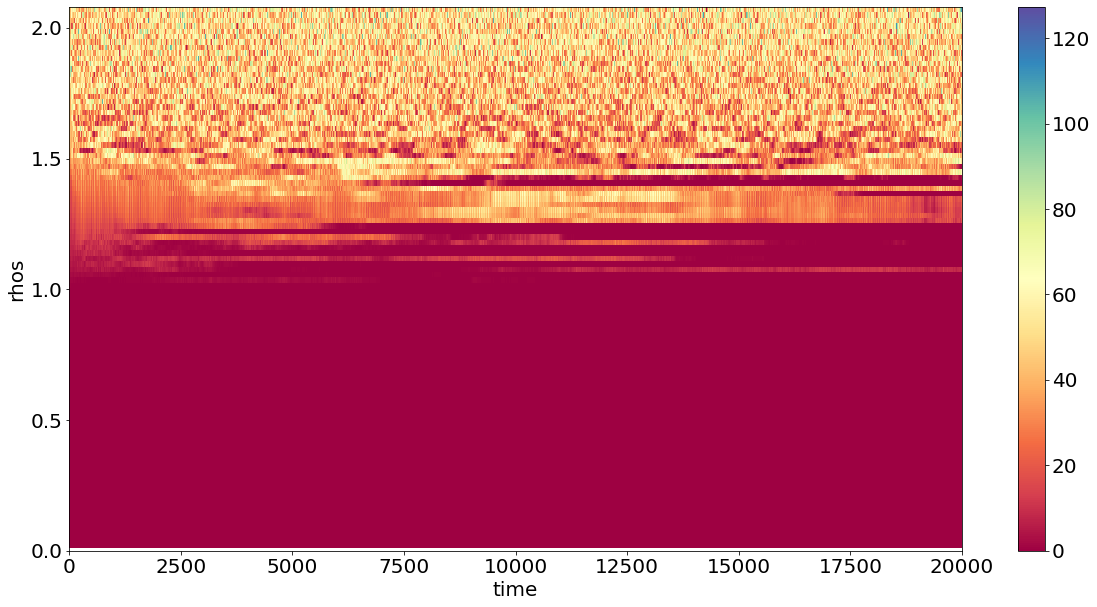

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)


dist=distance_ex_rhos.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, rhos[0], rhos[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', vmin=0, aspect='auto')#interpolation='nearest', 

ax1.set_xlabel('time')
ax1.set_ylabel('rhos')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)

## convergence of ex_input_scales, rho=1.1

In [ ]:
np.random.seed(1010)

Time_leng=2*10**4

pLow = 0.01
pHigh = 1.6
nSteps = 100      # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

dim_u_spon=0
dim_rv=50
dim_u=1
density=1.0

input_scale_spon = 0.4
ex_input_scales=np.arange(pLow, pHigh, pInc)
rho=1.1

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

#difference is defined by square norm of all states
distance_ex_inputs=np.ones((Time_leng, nSteps))
for i in range(nSteps):
    ex_input_scale=ex_input_scales[i]
    u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))

    rseed=1
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init1, plot=False, verbose=False)
    
    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                               rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                               spon_eps=0.20, spon_r=4.0, x_init=x_init2, plot=False, verbose=False)
    
    distance_ex_inputs[:, i]=np.sum((states_series1[:, :] - states_series2[:, :])**2, axis=1)



### Time vs input_scales, diff between two ESN

(100, 20000)
[0, 20000, 0.01, 1.5840999999999998]


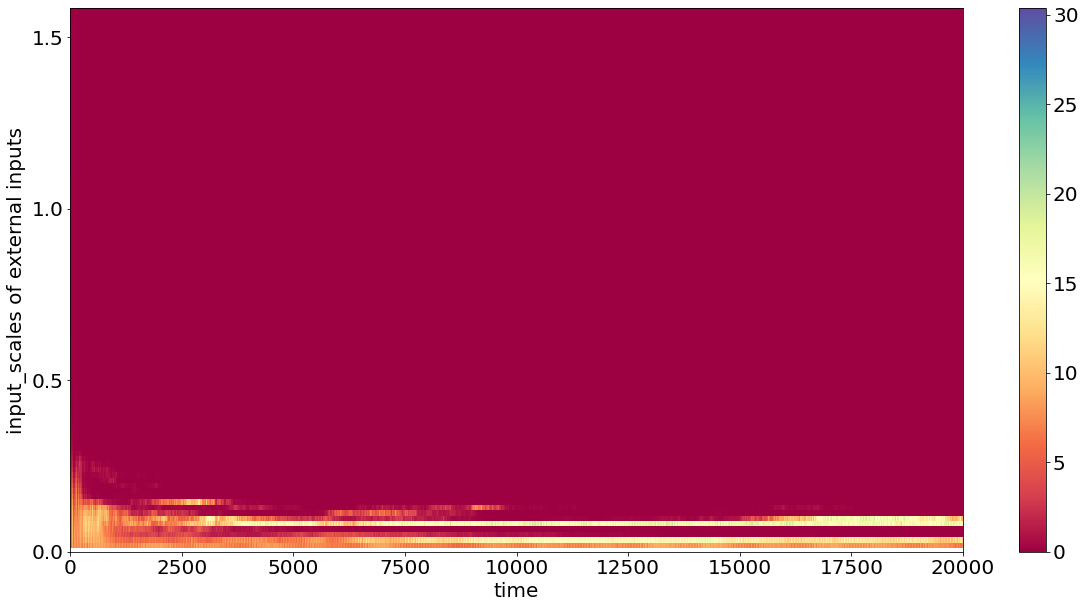

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

dist=distance_ex_inputs.T
print(dist.shape)

plot_len=2*10**4 #Time_leng
plot_data=dist[:,:plot_len]

extent=[0, plot_len, ex_input_scales[0], ex_input_scales[-1]]
print(extent)
bar1=ax1.imshow(plot_data[::-1,:], extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto')#interpolation='nearest', 
"""
interpolationについて
https://imagingsolution.net/imaging/interpolation/

a valid value for interpolation; supported values are 'antialiased', 'none', 
'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 
'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'
"""
ax1.set_xlabel('time')
ax1.set_ylabel('input_scales of external inputs')
ax1.set_yticks(np.arange(0, pHigh, 0.5))
fig.colorbar(bar1, ax=ax1)